In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
%matplotlib inline
plt.ion()

import os
import sys
import re
import pdb
import glob

import weblogolib
from IPython.display import Image

sns.set_style("whitegrid", {'axes.grid' : False})

In [2]:
RESULT_FILE_PATTERN = re.compile('(?P<directory>\S+)/results\.(?P<experiment>.*)\.txt')
EXPERIMENT_PATTERN = re.compile('(?P<locus>.+)_lib(?P<lib_num>[0-9]+)_rep(?P<rep_num>[0-9]+)')

class Result:
    ''' Class to hold information on a results file'''
    def __init__(self,file_name):
        self.valid=False
        m = re.match(RESULT_FILE_PATTERN,file_name)
        if m:
            self.data_file = file_name
            
            d1 = m.groupdict()
            self.directory = d1['directory']
            self.experiment = d1['experiment']
            self.report_file = '%s/report.results.%s.txt'%(self.directory,self.experiment)
            
            d2 = re.match(EXPERIMENT_PATTERN,self.experiment).groupdict()
            self.locus = d2['locus']
            self.lib_num = int(d2['lib_num'])
            self.rep_num = int(d2['rep_num'])
            self.valid=True

            # Read in data
            assert os.path.isfile(self.data_file)
            self.data_df = pd.read_csv(self.data_file,delim_whitespace=True).fillna(0)
            
            # Load report file
            assert os.path.isfile(self.report_file)
            with open(self.report_file) as f:
                self.report = f.read()

        
    def __repr__(self):
        return '%s_lib%d_rep%d'%(self.locus,self.lib_num,self.rep_num)

In [3]:
# Only load results for 9nt libraries
results_dir = '17.07.18_results'
results_glob = results_dir + '/results.*.txt'
results_dict = {}
file_names = glob.glob(results_glob)
for file_name in file_names:
    result = Result(file_name)
    if result.valid:
        name = repr(result)
        results_dict[name] = result
        print 'Loading %s ...'%name
print 'Done!'

Loading brca2_11nt_lib1_rep1 ...
Loading brca2_11nt_lib1_rep2 ...
Loading brca2_11nt_lib1_rep3 ...
Loading brca2_11nt_lib2_rep1 ...
Loading brca2_11nt_lib2_rep2 ...
Loading brca2_11nt_lib2_rep3 ...
Loading brca2_11nt_lib3_rep1 ...
Loading brca2_11nt_lib3_rep2 ...
Loading brca2_11nt_lib3_rep3 ...
Loading brca2_9nt_lib1_rep1 ...
Loading brca2_9nt_lib1_rep2 ...
Loading brca2_9nt_lib1_rep3 ...
Loading brca2_9nt_lib2_rep1 ...
Loading brca2_9nt_lib2_rep2 ...
Loading brca2_9nt_lib2_rep3 ...
Loading ikbkap_9nt_lib1_rep1 ...
Loading ikbkap_9nt_lib1_rep2 ...
Loading ikbkap_9nt_lib1_rep3 ...
Loading ikbkap_9nt_lib2_rep1 ...
Loading ikbkap_9nt_lib2_rep2 ...
Loading ikbkap_9nt_lib2_rep3 ...
Loading smn1_9nt_lib1_rep1 ...
Loading smn1_9nt_lib1_rep2 ...
Loading smn1_9nt_lib1_rep3 ...
Loading smn1_9nt_lib2_rep1 ...
Loading smn1_9nt_lib2_rep2 ...
Loading smn1_9nt_lib2_rep3 ...
Loading smn1_9nt_lib3_rep1 ...
Loading smn1_9nt_lib3_rep2 ...
Loading smn1_9nt_lib3_rep3 ...
Done!


In [4]:
# Separate results_dict according to the number of nt
results_11nt_dict = {}
results_9nt_dict = {}
for key, value in results_dict.iteritems():
    if '9nt' in key:
        results_9nt_dict[key] = value
    elif '11nt' in key:
        results_11nt_dict[key] = value

In [5]:
def get_counts(results_dict): 
    '''Returns a counts df containing the specified results.'''
    
    # Get sorted list of results names
    names = results_dict.keys()
    names.sort()
    
    # Compute counts marginalized over all barcoees
    counts_df = pd.DataFrame()
    for name in names:
        result = results_dict[name]
        x = result.data_df.groupby(['ss']).sum()
        counts_df[name+'_ex_ct'] = x['ex_ct'].astype(int)
        counts_df[name+'_tot_ct'] = x['tot_ct'].astype(int)
        
    # Transform all 'T' to 'U' in index
    counts_df['ss'] = [s.replace('T','U') for s in counts_df.index]
    counts_df.set_index('ss',drop=True,inplace=True)
    counts_df.fillna(0,inplace=True)

    return counts_df

In [6]:
get_name = lambda col: '_'.join(col.split('_')[:-2])

def ratios_from_counts(counts_df, min_tot_ct = 10):
    ''' Compute ratios from a set of counts. '''
    
    # Initialize dataframe
    ratios_df = pd.DataFrame()
    
    # Get list of experiments
    names = list(set([get_name(c) for c in counts_df.columns]))
    names.sort()
    
    # Compute ratios for each experiment
    for name in names:

        # Get counts for ex and tot samples
        try:
            ex_cts = counts_df[name+'_ex_ct'].fillna(0)
            tot_cts = counts_df[name+'_tot_ct'].fillna(0)
        except:
            pdb.set_trace()

        # Compute total number of identified reads for ex and tot samples
        ex_ct_sum = sum(ex_cts)
        tot_ct_sum = sum(tot_cts)

        # Compute indices with valid min tot_ct valies
        indices = tot_cts >= min_tot_ct

        # Compute normalized ratios
        ratios_df[name] = ((ex_cts/tot_cts)*(tot_ct_sum/ex_ct_sum))[indices]
    
    return ratios_df

In [7]:
# Get counts for 11nt datasets
counts_11nt_df = get_counts(results_11nt_dict)
print 'counts_11nt_df has %d entries'%len(counts_11nt_df)
counts_11nt_df.head()

counts_11nt_df has 444999 entries


,brca2_11nt_lib1_rep1_ex_ct,brca2_11nt_lib1_rep1_tot_ct,brca2_11nt_lib1_rep2_ex_ct,brca2_11nt_lib1_rep2_tot_ct,brca2_11nt_lib1_rep3_ex_ct,brca2_11nt_lib1_rep3_tot_ct,brca2_11nt_lib2_rep1_ex_ct,brca2_11nt_lib2_rep1_tot_ct,brca2_11nt_lib2_rep2_ex_ct,brca2_11nt_lib2_rep2_tot_ct,brca2_11nt_lib2_rep3_ex_ct,brca2_11nt_lib2_rep3_tot_ct,brca2_11nt_lib3_rep1_ex_ct,brca2_11nt_lib3_rep1_tot_ct,brca2_11nt_lib3_rep2_ex_ct,brca2_11nt_lib3_rep2_tot_ct,brca2_11nt_lib3_rep3_ex_ct,brca2_11nt_lib3_rep3_tot_ct
ss,,,,,,,,,,,,,,,,,,
AAAGACCGGGA,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGCAAAAAA,0,4,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGCAAAAAC,0,6,0,4,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGCAAAAAG,0,5,0,5,0,4,0.0,3.0,0.0,14.0,0.0,4.0,0.0,5.0,0.0,2.0,0.0,8.0
AAAGCAAAAAU,1,2,0,2,0,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,8.0,0.0,5.0


In [37]:
tmp_df = counts_11nt_df.copy()
tmp_df['ss_9nt'] = [c[:-2] for c in tmp_df.index]
tmp_df = tmp_df.groupby('ss_9nt').sum()
counts_11nt_marg_df = tmp_df.copy()
counts_11nt_marg_df.head()

,brca2_11nt_lib1_rep1_ex_ct,brca2_11nt_lib1_rep1_tot_ct,brca2_11nt_lib1_rep2_ex_ct,brca2_11nt_lib1_rep2_tot_ct,brca2_11nt_lib1_rep3_ex_ct,brca2_11nt_lib1_rep3_tot_ct,brca2_11nt_lib2_rep1_ex_ct,brca2_11nt_lib2_rep1_tot_ct,brca2_11nt_lib2_rep2_ex_ct,brca2_11nt_lib2_rep2_tot_ct,brca2_11nt_lib2_rep3_ex_ct,brca2_11nt_lib2_rep3_tot_ct,brca2_11nt_lib3_rep1_ex_ct,brca2_11nt_lib3_rep1_tot_ct,brca2_11nt_lib3_rep2_ex_ct,brca2_11nt_lib3_rep2_tot_ct,brca2_11nt_lib3_rep3_ex_ct,brca2_11nt_lib3_rep3_tot_ct
ss_9nt,,,,,,,,,,,,,,,,,,
AAAGACCGG,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGCAAAA,3,79,1,52,3,55,0.0,69.0,0.0,130.0,1.0,128.0,1.0,80.0,1.0,94.0,1.0,73.0
AAAGCAAAC,1,53,4,52,4,63,5.0,30.0,0.0,76.0,0.0,55.0,1.0,75.0,0.0,99.0,0.0,67.0
AAAGCAAAG,599,106,450,75,580,79,103.0,67.0,101.0,113.0,66.0,93.0,38.0,47.0,173.0,58.0,169.0,53.0
AAAGCAAAU,2,62,0,58,1,40,2.0,39.0,1.0,54.0,0.0,79.0,0.0,180.0,1.0,266.0,0.0,198.0


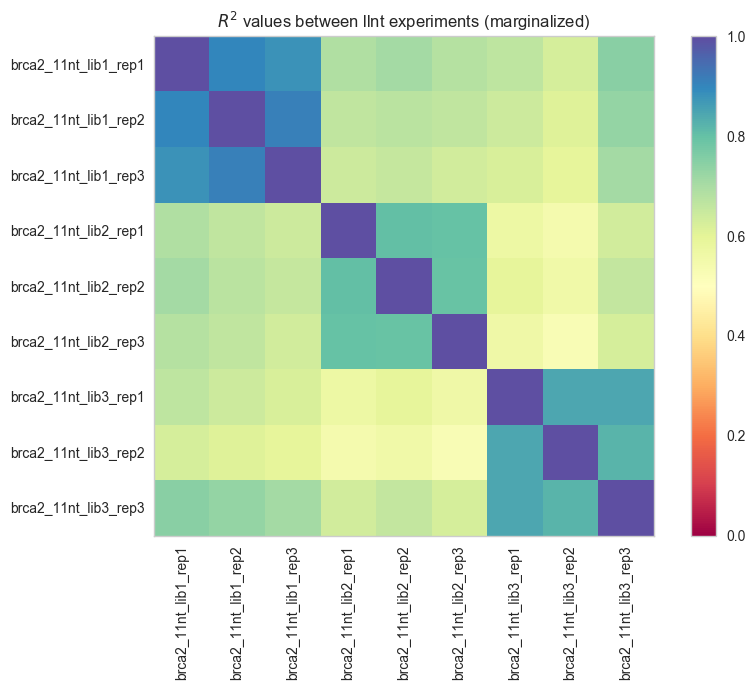

In [39]:
# Compute 11nt marg ratios
ratios_11nt_marg_df = ratios_from_counts(counts_11nt_marg_df, min_tot_ct=5)

# Compute correlation coefficients for ratios greater than a given cutoff
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=[9,7])
cols = ratios_11nt_marg_df.columns
num_samples = len(cols)
rhos = ratios_11nt_marg_df.corr()
plt.imshow(rhos**2,interpolation='nearest',vmin=0,vmax=1)
plt.xticks(range(num_samples),cols,rotation='vertical')
plt.yticks(range(num_samples),cols)
plt.colorbar()
plt.set_cmap('Spectral')
plt.title('$R^2$ values between llnt experiments (marginalized)')
plt.tight_layout()
plt.savefig('plots/experiment_correlations_11nt_marg.pdf')

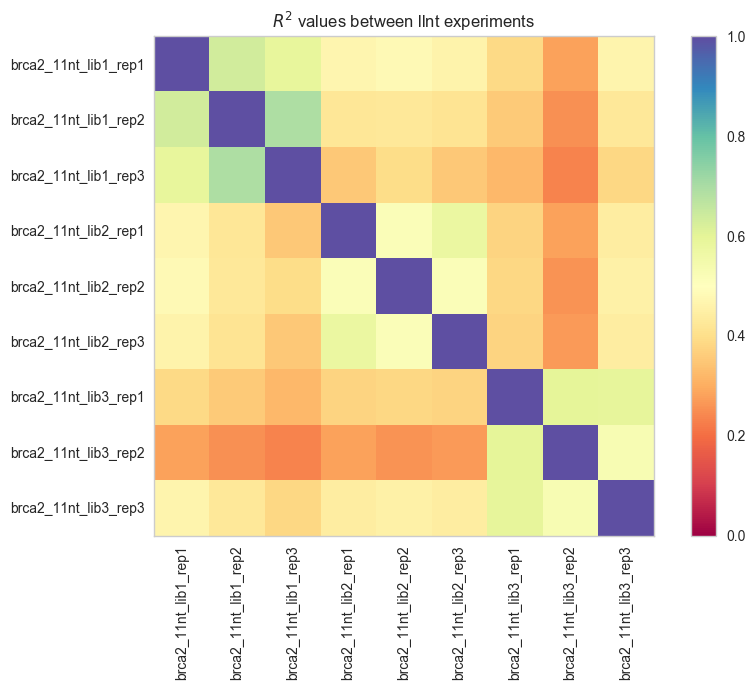

In [36]:
# Compute 11nt ratios
ratios_11nt_df = ratios_from_counts(counts_11nt_df, min_tot_ct=5)

# Compute correlation coefficients for ratios greater than a given cutoff
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=[9,7])
cols = ratios_11nt_df.columns
num_samples = len(cols)
rhos = ratios_11nt_df.corr()
plt.imshow(rhos**2,interpolation='nearest',vmin=0,vmax=1)
plt.xticks(range(num_samples),cols,rotation='vertical')
plt.yticks(range(num_samples),cols)
plt.colorbar()
plt.set_cmap('Spectral')
plt.title('$R^2$ values between llnt experiments')
plt.tight_layout()
plt.savefig('plots/experiment_correlations_11nt.pdf')

In [ ]:
# Marginalize counts across repliates for each lib
transpose_df = counts_11nt_df.transpose()
transpose_df['lib'] = [re.sub('_rep[0-9]','',c) for c in transpose_df.index]
transpose_lib_df = transpose_df.groupby('lib').sum()
counts_11nt_lib_df = transpose_lib_df.transpose()
counts_11nt_lib_df.head()

In [8]:
# Marginalize counts across repliates for each lib
transpose_df = counts_11nt_df.transpose()
transpose_df['lib'] = [re.sub('_rep[0-9]','',c) for c in transpose_df.index]
transpose_lib_df = transpose_df.groupby('lib').sum()
counts_11nt_lib_df = transpose_lib_df.transpose()
counts_11nt_lib_df.head()

lib,brca2_11nt_lib1_ex_ct,brca2_11nt_lib1_tot_ct,brca2_11nt_lib2_ex_ct,brca2_11nt_lib2_tot_ct,brca2_11nt_lib3_ex_ct,brca2_11nt_lib3_tot_ct
ss,,,,,,
AAAGACCGGGA,0.0,1.0,0.0,0.0,0.0,0.0
AAAGCAAAAAA,0.0,5.0,0.0,0.0,0.0,0.0
AAAGCAAAAAC,0.0,14.0,0.0,0.0,0.0,0.0
AAAGCAAAAAG,0.0,14.0,0.0,21.0,0.0,15.0
AAAGCAAAAAU,1.0,6.0,0.0,0.0,1.0,19.0


In [9]:
# Compute 11nt ratios
ratios_11nt_lib_df = ratios_from_counts(counts_11nt_lib_df, min_tot_ct=5)

# Compute median ratio of consensus ss
cons_seq = 'CAGGUAAGU'
rows = [i[:-2]==cons_seq for i in ratios_11nt_lib_df.index]
cons_df = ratios_11nt_lib_df[rows]
medians = cons_df.median(axis=0)

# Normalize each column to expression of consensus splice site
cols = ratios_11nt_lib_df.columns
for n, col in enumerate(cols):  
    ratios_11nt_lib_df[col] /= medians[col]
    
ratios_11nt_lib_df.head()

,brca2_11nt_lib1,brca2_11nt_lib2,brca2_11nt_lib3
ss,,,
AAAGCAAAAAA,0.000000,NaN,NaN
AAAGCAAAAAC,0.000000,NaN,NaN
AAAGCAAAAAG,0.000000,0.0,0.000000
AAAGCAAAAAU,0.011656,NaN,0.009114
AAAGCAAAACC,0.009991,NaN,NaN


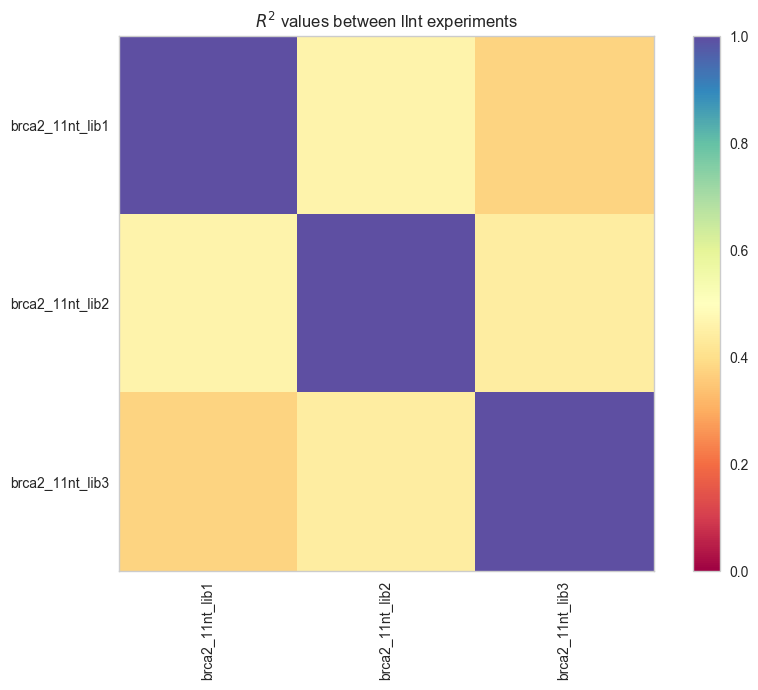

In [33]:
# Compute correlation coefficients for ratios greater than a given cutoff
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=[9,7])
cols = ratios_11nt_lib_df.columns
num_samples = len(cols)
rhos = ratios_11nt_lib_df.corr()
plt.imshow(rhos**2,interpolation='nearest',vmin=0,vmax=1)
plt.xticks(range(num_samples),cols,rotation='vertical')
plt.yticks(range(num_samples),cols)
plt.colorbar()
plt.set_cmap('Spectral')
plt.title('$R^2$ values between llnt experiments')
plt.tight_layout()
plt.savefig('plots/experiment_correlations_11nt_lib.pdf')

In [10]:
# Grab sites above threshold for each library
threshold = .5
sites_dict = {}
for col in ratios_11nt_lib_df.columns:  
    indices = ratios_11nt_lib_df[col]>threshold
    sites_dict[col] = ratios_11nt_lib_df.index[indices]
    print col, len(sites_dict[col])

brca2_11nt_lib1 14704
brca2_11nt_lib2 6891
brca2_11nt_lib3 9758


In [11]:
# Write selected sites to disk in fasta format
def make_logo(sites,out_file_base):
    '''
    Creates a weblogo for a set of sites.
    Makes 2 output files, one with .pdf extension
    and one with .png extension
    '''
    
    out_file_png = out_file_base+'.png'
    out_file_pdf = out_file_base+'.pdf'
        
    # Write sites to tmp fasta file
    tmp_sites_file = 'tmp.sites.fa'
    site_entries = ['>%d\n%s\n'%(num,site) for (num,site) in enumerate(sites)]
    with open(tmp_sites_file,'w') as f:
         f.write(''.join(site_entries))
            
    # Read in sequences from tmp fasta file
    fin = open(tmp_sites_file)
    seqs = weblogolib.read_seq_data(fin)
    os.remove(tmp_sites_file)
    
    # Create weblogo and save as tmp pdf file
    data = weblogolib.LogoData.from_seqs(seqs)
    options = weblogolib.LogoOptions()
    options.color_scheme = weblogolib.classic
    logo_format = weblogolib.LogoFormat(data,options)
    pdf = weblogolib.pdf_formatter(data,logo_format)
    with open(out_file_pdf,'w') as fout:
        fout.write(pdf)
        
    # Convert tmp pdf file to out_file (a png file)
    command = 'sips -s format png %s --out %s '%(out_file_pdf,out_file_png)
    os.system(command)

------------------

In [12]:
# Get counts for 9nt datasets
counts_9nt_df = get_counts(results_9nt_dict)
print 'counts_9nt_df has %d entries'%len(counts_9nt_df)
counts_9nt_df.head()

counts_9nt_df has 32799 entries


,brca2_9nt_lib1_rep1_ex_ct,brca2_9nt_lib1_rep1_tot_ct,brca2_9nt_lib1_rep2_ex_ct,brca2_9nt_lib1_rep2_tot_ct,brca2_9nt_lib1_rep3_ex_ct,brca2_9nt_lib1_rep3_tot_ct,brca2_9nt_lib2_rep1_ex_ct,brca2_9nt_lib2_rep1_tot_ct,brca2_9nt_lib2_rep2_ex_ct,brca2_9nt_lib2_rep2_tot_ct,...,smn1_9nt_lib2_rep2_ex_ct,smn1_9nt_lib2_rep2_tot_ct,smn1_9nt_lib2_rep3_ex_ct,smn1_9nt_lib2_rep3_tot_ct,smn1_9nt_lib3_rep1_ex_ct,smn1_9nt_lib3_rep1_tot_ct,smn1_9nt_lib3_rep2_ex_ct,smn1_9nt_lib3_rep2_tot_ct,smn1_9nt_lib3_rep3_ex_ct,smn1_9nt_lib3_rep3_tot_ct
ss,,,,,,,,,,,,,,,,,,,,,
AAAGAUAUU,0,0,0,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGCAAAA,2,106,4,101,7,110,18.0,173.0,8.0,154.0,...,5.0,558.0,2.0,285.0,2.0,236.0,1.0,24.0,0.0,262.0
AAAGCAAAC,6,96,5,109,16,89,8.0,48.0,0.0,40.0,...,7.0,365.0,0.0,103.0,3.0,135.0,6.0,31.0,3.0,120.0
AAAGCAAAG,9,89,6,93,19,108,1.0,70.0,0.0,69.0,...,3.0,146.0,2.0,86.0,2.0,344.0,2.0,39.0,4.0,334.0
AAAGCAAAU,14,311,17,294,44,279,6.0,136.0,0.0,121.0,...,4.0,546.0,3.0,347.0,2.0,448.0,6.0,39.0,5.0,211.0


In [13]:
# Marginalize counts across repliates for each lib
transpose_df = counts_9nt_df.transpose()
transpose_df['lib'] = [re.sub('_rep[0-9]','',c) for c in transpose_df.index]
transpose_lib_df = transpose_df.groupby('lib').sum()
counts_9nt_lib_df = transpose_lib_df.transpose()
counts_9nt_lib_df.head()

lib,brca2_9nt_lib1_ex_ct,brca2_9nt_lib1_tot_ct,brca2_9nt_lib2_ex_ct,brca2_9nt_lib2_tot_ct,ikbkap_9nt_lib1_ex_ct,ikbkap_9nt_lib1_tot_ct,ikbkap_9nt_lib2_ex_ct,ikbkap_9nt_lib2_tot_ct,smn1_9nt_lib1_ex_ct,smn1_9nt_lib1_tot_ct,smn1_9nt_lib2_ex_ct,smn1_9nt_lib2_tot_ct,smn1_9nt_lib3_ex_ct,smn1_9nt_lib3_tot_ct
ss,,,,,,,,,,,,,,
AAAGAUAUU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGCAAAA,13.0,317.0,109.0,517.0,28.0,170.0,29.0,1032.0,0.0,99.0,11.0,1092.0,3.0,522.0
AAAGCAAAC,27.0,294.0,33.0,145.0,13.0,236.0,12.0,208.0,7.0,441.0,10.0,556.0,12.0,286.0
AAAGCAAAG,34.0,290.0,38.0,247.0,32.0,485.0,4.0,231.0,5.0,279.0,6.0,299.0,8.0,717.0
AAAGCAAAU,75.0,884.0,64.0,459.0,28.0,368.0,4.0,232.0,9.0,974.0,10.0,1200.0,13.0,698.0


In [14]:
# Compute ratios
ratios_9nt_lib_df = ratios_from_counts(counts_9nt_lib_df,min_tot_ct=5)

# Compute median ratio of consensus ss
cons_seq = 'CAGGUAAGU'
medians = ratios_9nt_lib_df.loc[cons_seq,:]

# Normalize each column to expression of consensus splice site
cols = ratios_9nt_lib_df.columns
for n, col in enumerate(cols):  
    ratios_9nt_lib_df[col] /= medians[col]
    
ratios_9nt_lib_df.head()

,brca2_9nt_lib1,brca2_9nt_lib2,ikbkap_9nt_lib1,ikbkap_9nt_lib2,smn1_9nt_lib1,smn1_9nt_lib2,smn1_9nt_lib3
ss,,,,,,,
AAAGCAAAA,0.003251,0.010923,0.001910,0.000511,0.000000,0.002695,0.000736
AAAGCAAAC,0.007280,0.011791,0.000639,0.001049,0.004953,0.004811,0.005376
AAAGCAAAG,0.009294,0.007971,0.000765,0.000315,0.005593,0.005368,0.001430
AAAGCAAAU,0.006726,0.007224,0.000882,0.000313,0.002884,0.002229,0.002386
AAAGCAACA,0.006346,0.006396,0.001074,0.000974,0.002256,0.006221,0.005922


In [24]:
# Grab 9nt sites above threshold for each library
threshold = .5
sites_dict = {}
for col in ratios_9nt_lib_df.columns:  
    indices = ratios_9nt_lib_df[col]>threshold
    sites_dict[col] = ratios_9nt_lib_df.index[indices]

for key, val in sites_dict.iteritems():
    print key, len(val)

smn1_9nt_lib2 1235
smn1_9nt_lib3 1387
smn1_9nt_lib1 1120
brca2_9nt_lib2 925
brca2_9nt_lib1 954
ikbkap_9nt_lib2 193
ikbkap_9nt_lib1 181


In [26]:
# Grab 11nt sites above threshold for each library
threshold = .5
for col in ratios_11nt_lib_df.columns:  
    indices = ratios_11nt_lib_df[col]>threshold
    sites_dict[col] = ratios_11nt_lib_df.index[indices]

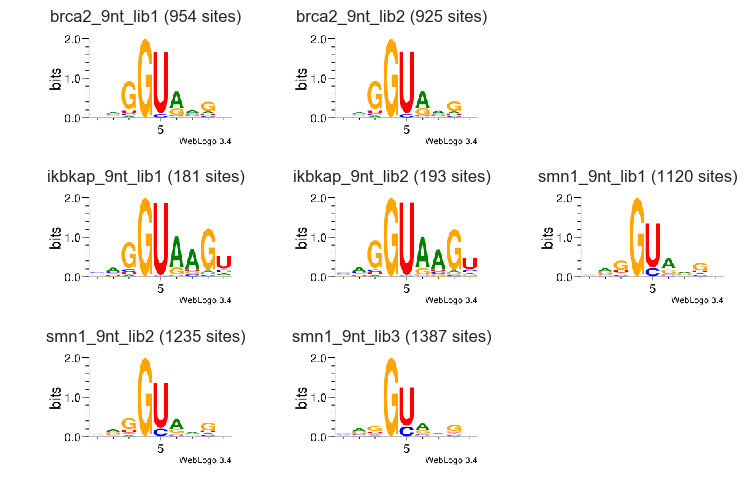

In [28]:
# Create 9nt logos 
plt.figure(figsize=[9,6])
subplots = [1,2,4,5,6,7,8]
names = [n for n in sites_dict.keys() if '9nt' in n]
names.sort()

for n, name in enumerate(names):
    logo_file = 'logos/logo_%s'%name
    sites = sites_dict[name]
    make_logo(sites,logo_file)
    image_file = logo_file+'.png'
    image = mpimg.imread(image_file)
    plt.subplot(3,3,subplots[n])
    plt.imshow(image) 
    plt.axis('off')
    plt.title('%s (%d sites)'%(name,len(sites)))
    
plt.savefig('plots/logos_9nt_libs.png', dpi=300)

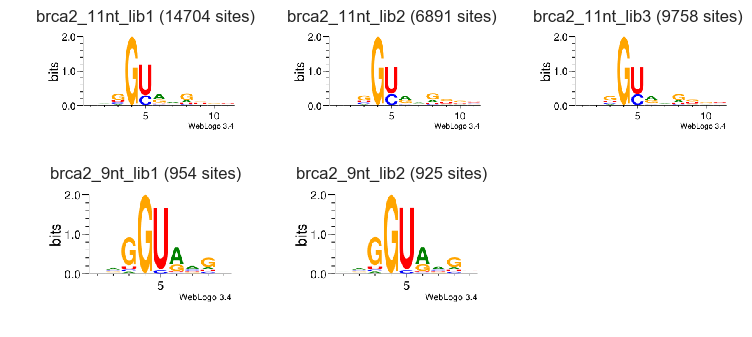

In [31]:
# Create brca2 logos 
plt.figure(figsize=[9,4])
subplots = [1,2,3,4,5]
names = [n for n in sites_dict.keys() if 'brca2' in n]
names.sort()

for n, name in enumerate(names):
    logo_file = 'logos/logo_%s'%name
    sites = sites_dict[name]
    make_logo(sites,logo_file)
    image_file = logo_file+'.png'
    image = mpimg.imread(image_file)
    plt.subplot(2,3,subplots[n])
    plt.imshow(image) 
    plt.axis('off')
    plt.title('%s (%d sites)'%(name,len(sites)))
    
plt.savefig('plots/logos_brca2_libs.png', dpi=300)

------

In [35]:
# Compute correlation coefficients for ratios greater than a given cutoff
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=[8,8])
cols = ratios_df.columns
num_samples = len(cols)
rhos = ratios_df.corr()
plt.imshow(rhos**2,interpolation='nearest',vmin=0,vmax=1)
plt.xticks(range(num_samples),cols,rotation='vertical')
plt.yticks(range(num_samples),cols)
plt.colorbar()
plt.set_cmap('Spectral')
plt.title('$R^2$ values between experiments')
#print rhos

NameError: name 'ratios_df' is not defined

**It looks to me like the 11nt libraries are suffering from a lot of incorrect ss-bc associations. This is why there is substantially higher  concordence within a library than between libraries.**

In [ ]:
x_col = 'brca2_11nt_lib1_rep1'
y_col = 'brca2_11nt_lib2_rep3'
plt.plot(ratios_df[x_col],ratios_df[y_col],'.')
plt.xlabel(x_col)
plt.ylabel(y_col)

In [ ]:
# Compute median ratios across replicates and libraries
median_ratios_df = pd.DataFrame()
experiments = ['brca2_9nt','brca2_11nt']
for experiment in experiments:
    ratio_cols = [c for c in ratios_df.columns if experiment in str(c)]
    tmp_df = ratios_df[ratio_cols]
    medians = tmp_df.median(axis=1,skipna=True)
    median_ratios_df[experiment] = medians
    
median_ratios_df.head()

In [ ]:
print 'Before filtering: num splice sites == %d'%len(median_ratios_df)

# Clean out shifted splice sites
pattern = re.compile('.GUG[CU]....')
all_ss = median_ratios_df.index.values
ok_ss = [ss for ss in all_ss if not re.match(pattern,ss)]
median_ratios_df = median_ratios_df.loc[ok_ss,:]

print 'After filtering: num splice sites == %d'%len(median_ratios_df)

In [ ]:
# Normalize each column to expression of consensus splice site
cons_seq = 'CAGGUAAGU'
cols = median_ratios_df.columns
for n, col in enumerate(cols):  
    ratio_cons = median_ratios_df.loc[cons_seq,col]
    median_ratios_df[col] /= ratio_cons

In [ ]:
pct_threshold = 5

plt.figure(figsize=[12,4])
cols = median_ratios_df.columns
for n, col in enumerate(cols):  
    pcts = 100*median_ratios_df[col].dropna().values
    pcts[pcts > 100] = 100
    
    plt.subplot(2,3,n+1)
    indices = pcts > pct_threshold
    plt.hist(pcts,20)
    plt.xlabel('percent of cons')
    plt.ylabel('num splice sites')
    plt.xlim([0,100])
    plt.ylim([0,550])
    plt.axvline(pct_threshold,linestyle=':',color='tomato')
    plt.title('%s ss above %d%% of cons: %d'%(col, pct_threshold, sum(indices)))
    
plt.tight_layout()

In [ ]:
plt.figure(figsize=[12,4])
pairs = [(0,1)]
num_pairs = len(pairs)

wt_ss_dict = {'brca2':     'CAGGCAAGU', 
              'ikbkap':    'CAAGUAAGU', 
              'smn1':      'GGAGUAAGU', 
              'cons':      'CAGGUAAGU', 
              'ikbkap_mut':'CAAGUAAGC'}

#activity_thresolds = {'brca2_9nt':12, 'smn1_9nt':12, 'ikbkap_9nt':50}

brca2_threshold = .5

cols = median_ratios_df.columns
for n, pair in enumerate(pairs):
    x_col = cols[pair[0]]
    y_col = cols[pair[1]]    
    xs = median_ratios_df[x_col].values
    ys = median_ratios_df[y_col].values

    plt.subplot(1,num_pairs,n+1)
    plt.plot(xs,ys,'.k',label=None)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    
    for name in wt_ss_dict:
        ss = wt_ss_dict[name]
        x = median_ratios_df.loc[ss,x_col]
        y = median_ratios_df.loc[ss,y_col]
        plt.plot(x,y,'o',label=name, markeredgecolor='k', markersize=10, markeredgewidth=1)
        
    plt.legend()
    
plt.tight_layout()

In [ ]:
logo_file = 'logos/logo_brca2_9nt'
indices = median_ratios_df['brca2_9nt'] > .5
sites = median_ratios_df.index[indices]
make_logo(sites,logo_file)
print 'High in brca2: %d sites'%indices.sum()
Image(filename=logo_file+'.png',height=200) 

In [ ]:
logo_file = 'logos/logo_brca2_11nt'
indices = median_ratios_df['brca2_11nt'] > .5
sites = median_ratios_df.index[indices]
make_logo(sites,logo_file)
print 'High in brca2: %d sites'%indices.sum()
Image(filename=logo_file+'.png',height=200) 